## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [5]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

In [12]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -p data/planet/

train-jpg.tar.7z: Downloaded 600MB of 600MB to data/planet
test-jpg.tar.7z: Downloaded 603MB of 603MB to data/planet
train-tif-v2.tar.7z: Downloaded 13GB of 13GB to data/planet
test-tif-v2.tar.7z: Downloaded 19GB of 19GB to data/planet
test-jpg-additional.tar.7z: Downloaded 304MB of 304MB to data/planet
Kaggle-planet-test-tif.torrent: Downloaded 2MB of 2MB to data/planet
Kaggle-planet-train-tif.torrent: Downloaded 1MB of 1MB to data/planet
sample_submission_v2.csv.zip: Downloaded 154KB of 154KB to data/planet
train_v2.csv.zip: Downloaded 159KB of 159KB to data/planet
test_v2_file_mapping.csv.zip: Downloaded 110KB of 110KB to data/planet


In [37]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv.zip -p data/planet/

train_v2.csv.zip: Downloaded 159KB of 159KB to data/planet


In [23]:
!7z x "data/planet/*-jpg.tar.7z" -o"data/planet/"

In [38]:
!7z x "data/planet/train_v2.csv.zip" -o"data/planet/"


7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,4 CPUs)

Processing archive: data/planet/train_v2.csv.zip

file data/planet/train_v2.csv
already exists. Overwrite with 
train_v2.csv?
(Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? ^C
(Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

In [30]:
!tar -xvf "data/planet/train-jpg.tar" -C "data/planet/" > /dev/null
!tar -xvf "data/planet/test-jpg.tar" -C "data/planet/" > /dev/null

train-jpg/
train-jpg/train_21777.jpg
train-jpg/train_34567.jpg
train-jpg/train_7212.jpg
train-jpg/train_11485.jpg
train-jpg/train_14111.jpg
train-jpg/train_8634.jpg
train-jpg/train_27649.jpg
train-jpg/train_8459.jpg
train-jpg/train_12520.jpg
train-jpg/train_25962.jpg
train-jpg/train_14764.jpg
train-jpg/train_17626.jpg
train-jpg/train_25677.jpg
train-jpg/train_9660.jpg
train-jpg/train_1366.jpg
train-jpg/train_26122.jpg
train-jpg/train_24548.jpg
train-jpg/train_17415.jpg
train-jpg/train_25901.jpg
train-jpg/train_23389.jpg
train-jpg/train_25095.jpg
train-jpg/train_12922.jpg
train-jpg/train_19885.jpg
train-jpg/train_37550.jpg
train-jpg/train_21305.jpg
train-jpg/train_40436.jpg
train-jpg/train_31247.jpg
train-jpg/train_1837.jpg
train-jpg/train_6289.jpg
train-jpg/train_36691.jpg
train-jpg/train_16062.jpg
train-jpg/train_28673.jpg
train-jpg/train_22394.jpg
train-jpg/train_14346.jpg
train-jpg/train_13177.jpg
train-jpg/train_12481.jpg
train-jpg/train_3923.jpg
train-jpg/train_36787.jpg
train-jpg

In [31]:
ls {PATH}

Kaggle-planet-test-tif.torrent   test-tif-v2.tar.7z
Kaggle-planet-train-tif.torrent  test_v2_file_mapping.csv.zip
sample_submission_v2.csv.zip     train-jpg/
test-jpg/                        train-jpg.tar
test-jpg-additional.tar          train-jpg.tar.7z
test-jpg-additional.tar.7z       train-tif-v2.tar.7z
test-jpg.tar                     train_v2.csv@
test-jpg.tar.7z                  train_v2.csv.zip
test-tif-v2.tar


## Multi-label versus single-label classification

In [26]:
from fastai.plots import *

In [27]:
def get_1st(path): return glob(f'{path}/*.*')[0]

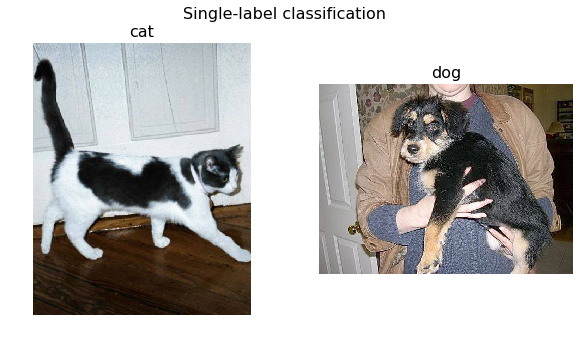

In [28]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

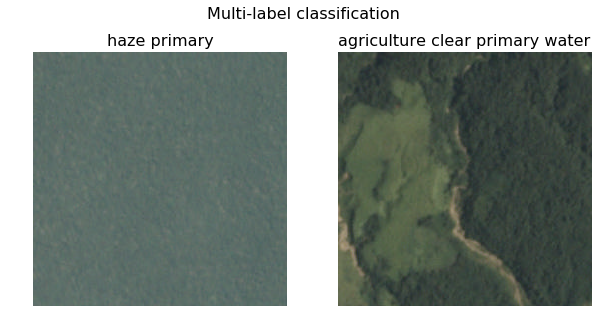

In [33]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [34]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [39]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [40]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [41]:
data = get_data(256)

In [42]:
x,y = next(iter(data.val_dl))

In [36]:
y


    1     0     0  ...      0     1     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

In [43]:
list(zip(data.classes, y[0]))

[('agriculture', tensor(1., device='cuda:0')),
 ('artisinal_mine', tensor(0., device='cuda:0')),
 ('bare_ground', tensor(0., device='cuda:0')),
 ('blooming', tensor(0., device='cuda:0')),
 ('blow_down', tensor(0., device='cuda:0')),
 ('clear', tensor(1., device='cuda:0')),
 ('cloudy', tensor(0., device='cuda:0')),
 ('conventional_mine', tensor(0., device='cuda:0')),
 ('cultivation', tensor(0., device='cuda:0')),
 ('habitation', tensor(0., device='cuda:0')),
 ('haze', tensor(0., device='cuda:0')),
 ('partly_cloudy', tensor(0., device='cuda:0')),
 ('primary', tensor(1., device='cuda:0')),
 ('road', tensor(0., device='cuda:0')),
 ('selective_logging', tensor(0., device='cuda:0')),
 ('slash_burn', tensor(0., device='cuda:0')),
 ('water', tensor(1., device='cuda:0'))]

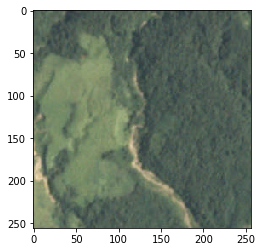

In [46]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [47]:
sz=64

In [48]:
data = get_data(sz)

In [49]:
data = data.resize(int(sz*1.3), 'tmp')

In [11]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

A Jupyter Widget

[ 0.       0.22404  0.31176  0.82044]                        



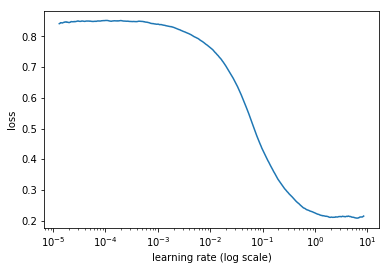

In [15]:
lrf=learn.lr_find()
learn.sched.plot()

In [12]:
lr = 0.2

In [13]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.14882  0.13552  0.87878]                        
[ 1.       0.14237  0.13048  0.88251]                        
[ 2.       0.13675  0.12779  0.88796]                        
[ 3.       0.13528  0.12834  0.88419]                        
[ 4.       0.13428  0.12581  0.88879]                        
[ 5.       0.13237  0.12361  0.89141]                        
[ 6.       0.13179  0.12472  0.8896 ]                        



In [14]:
lrs = np.array([lr/9,lr/3,lr])

In [15]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.12534  0.10926  0.90892]                        
[ 1.       0.12035  0.10086  0.91635]                        
[ 2.       0.11001  0.09792  0.91894]                        
[ 3.       0.1144   0.09972  0.91748]                        
[ 4.       0.11055  0.09617  0.92016]                        
[ 5.       0.10348  0.0935   0.92267]                        
[ 6.       0.10502  0.09345  0.92281]                        



In [19]:
learn.save(f'{sz}')

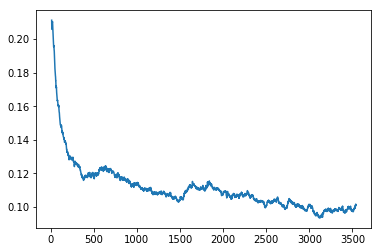

In [22]:
learn.sched.plot_loss()

In [20]:
sz=128

In [21]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09729  0.09375  0.91885]                         
[ 1.       0.10118  0.09243  0.92075]                         
[ 2.       0.09805  0.09143  0.92235]                         
[ 3.       0.09834  0.09134  0.92263]                         
[ 4.       0.096    0.09046  0.9231 ]                         
[ 5.       0.09584  0.09035  0.92403]                         
[ 6.       0.09262  0.09059  0.92358]                         



In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09623  0.08693  0.92696]                         
[ 1.       0.09371  0.08621  0.92887]                         
[ 2.       0.08919  0.08296  0.93113]                         
[ 3.       0.09221  0.08579  0.92709]                         
[ 4.       0.08994  0.08575  0.92862]                         
[ 5.       0.08729  0.08248  0.93108]                         
[ 6.       0.08218  0.08315  0.92971]                         



In [23]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [26]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [27]:
f2(preds,y)

0.93626519738612801

### End